# Amazon Product Recommendation</center>
Alvita Yathati

In this project we are going to build recommendation model for the electronics products of Amazon.
### Dataset
dataset are:
- **userId**
- **productId**
- **ratings**
- **timestamp**

---
### Imports and Configurations

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357246 sha256=079e94cae08e04a9b4a5b17bd4b94597a79ab0787e144b5df543482d8d3b1aa4
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
# Utilities
import math, random, warnings
from time import time
from datetime import datetime
from collections import defaultdict
from IPython.core.interactiveshell import InteractiveShell

# Mathematical calculation
import numpy as np
from scipy.sparse.linalg import svds
from sklearn import model_selection
from sklearn.metrics.pairwise import cosine_similarity

# Data handling
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-surprise recommender package
from surprise import SVD, KNNWithMeans, KNNBasic
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.prediction_algorithms.baseline_only import BaselineOnly

In [ ]:
# Configure for any default setting of any library
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')
%matplotlib inline
# sns.set(style='whitegrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

**Comments**
- **InteractiveShell** setting displays the full output for a cell, not just the latest one.
- Ignore all warnings in the notebook for an user friendly view
- **%matplotlib inline** sets the backend of matplotlib to the 'inline' backend: With this backend, the output of plotting commands is displayed inline without needing to call plt.show() every time a data is plotted.
- **sns.set()** sets few of the Seaborn's asthetic parameters
- Pandas **display.float_format** supress the scintific notation in pandas dataframe for easy readbability

---
## Q1. Read and explore the given dataset.  (Rename column/add headers, plot histograms, find data characteristics)
### Load the Dataset

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset into a Pandas dataframe called ratingsand skip any lines that return an error
ratings = pd.read_csv('/content/drive/MyDrive/Elective project/ratings_Electronics.csv',
                      names=['userId', 'productId', 'rating', 'timestamp'],
                      on_bad_lines='skip',
                     )

# Save an original copy of the dataframe
ratings_original = ratings.copy(deep=True)

In [ ]:
# Check the head of the dataset
ratings.head()
# Check the tail of the dataset
ratings.tail()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.000,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.000,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.000,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.000,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.000,1334707200


,userId,productId,rating,timestamp
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.000,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.000,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.000,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.000,1297555200
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.000,1312675200


**Comments**
- To take a closer look at the data, pandas library provides **“.head()”** function which returns first five observations and **“.tail()”** function which returns last five observations of the data set.

### Inspect the Dataset

In [ ]:
# Get the shape and size of the dataset
print("Number of rows    :",ratings.shape[0])
print("Number of columns :",ratings.shape[1])

Number of rows    : 7824482
Number of columns : 4


In [ ]:
# Get more info on it
# 1. Name of the columns
# 2. Find the data types of each columns
# 3. Look for any null/missing values
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [ ]:
# Check for any Null values in the dataset
ratings.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

**Observations**
- The dataset comprises of **7824482 rows** and **4 columns**.
- There are **NO null/missing** present in the dataset.
- int64 datatype of timestamp column indicates that it is in **Unix timestamp** format where each number is the number of seconds passed after **January 1, 1970 at UTC**.

#### Drop Duplicates
It's not certain how this data was collected or if it processed before it was published; there could be some duplicated ratings in here. To check, we'll see if there are any duplicated userId and productId combination.

In [ ]:
# Get a dataframe consisting only of ratings that are duplicated
rating_combination = ['userId', 'productId']
ratings[ratings.duplicated(subset=rating_combination, keep=False)].sort_values(rating_combination).head()

# ratings.drop_duplicates(subset=['userId','productId','rating'],inplace=True)

,userId,productId,rating,timestamp


In [ ]:
# Drop the timestamp column
ratings.drop(labels='timestamp', axis=1, inplace=True)
ratings.head()

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.000
1,A2CX7LUOHB2NDG,0321732944,5.000
2,A2NWSAGRHCP8N5,0439886341,1.000
3,A2WNBOD3WNDNKT,0439886341,3.000
4,A1GI0U4ZRJA8WN,0439886341,1.000


In [ ]:
# Check the count of unique user and product data
unique_original = (ratings.userId.nunique(), ratings.productId.nunique())
print('Count of unique Users    :', unique_original[0])
print('Count of unique Products :', unique_original[1])

Count of unique Users    : 4201696
Count of unique Products : 476002


In [ ]:
# Find the minimum and maximum ratings
print("The Minimum rating is:",ratings.rating.min())
print("The Maximum rating is:",ratings.rating.max())

The Minimum rating is: 1.0
The Maximum rating is: 5.0


Count of observations in each ratings:


rating
5.000    4347541
4.000    1485781
1.000     901765
3.000     633073
2.000     456322
Name: count, dtype: int64

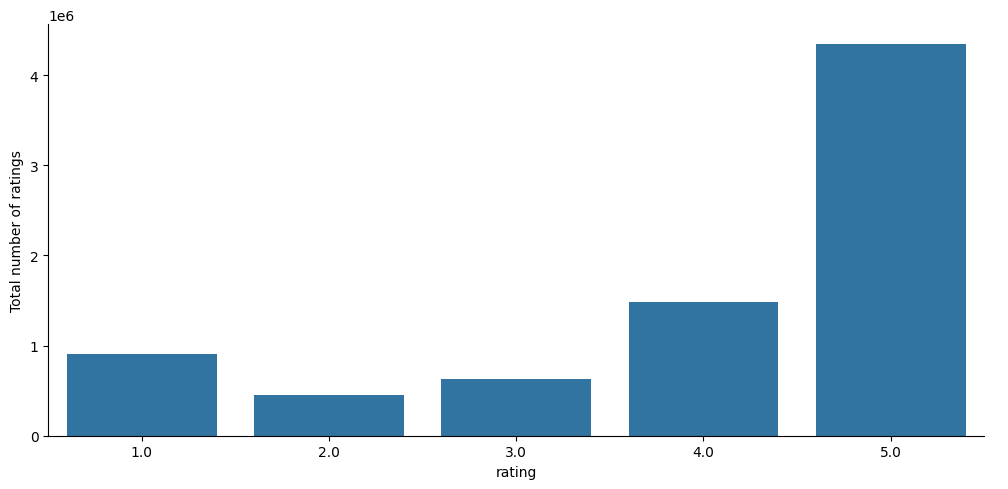

In [ ]:
# Check the distribution of ratings
print('Count of observations in each ratings:')
ratings.rating.value_counts()
g = sns.catplot(x="rating", data=ratings, aspect=2.0, kind='count')
g.set_ylabels("Total number of ratings")

In [ ]:
# Find the unique products under each ratings
ratings.groupby('rating')['productId'].nunique()

rating
1.000    176283
2.000    123419
3.000    152827
4.000    223845
5.000    358458
Name: productId, dtype: int64

**Observations:**
- Extreme high count in rating 5 indicates Amazon delivers good quality products in electronics department.
- Count plot and number of unique product under each rating category shows that there is more frequency under rating 5 followed by rating 4 and rating 1.
- This means ideally people are more sensitive towards extreme experiences. In other words more ratings can be observed when users are extremely satisfied or extremely unsatisfied.
- Users do not bother to rate usually for the average experience with any product, so is the reason rating 2 and 3 are having lesser frequency compared to others.

---
## Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings)


In [ ]:
# Find the top 10 users based on ratings
most_rated = ratings.userId.value_counts().rename_axis('UserId').reset_index(name='# ratings')
# most_rated = ratings.groupby('userId').size().sort_values(ascending=False)
most_rated.head(10)

,UserId,# ratings
0,A5JLAU2ARJ0BO,520
1,ADLVFFE4VBT8,501
2,A3OXHLG6DIBRW8,498
3,A6FIAB28IS79,431
4,A680RUE1FDO8B,406
5,A1ODOGXEYECQQ8,380
6,A36K2N527TXXJN,314
7,A2AY4YUOX2N1BQ,311
8,AWPODHOB4GFWL,308
9,ARBKYIVNYWK3C,296


### Density of the matrix


In [ ]:
# Find the density of the rating matrix
print('Total observed ratings in the dataset  :', len(ratings))
possible_num_of_ratings = ratings.userId.nunique() * ratings.productId.nunique()
print('Total ratings possible for the dataset :', possible_num_of_ratings)
density = len(ratings) / possible_num_of_ratings * 100
print('Density of the dataset                 : {:4.5f}%'.format(density))

Total observed ratings in the dataset  : 7824482
Total ratings possible for the dataset : 2000015699392
Density of the dataset                 : 0.00039%


**Getting rid of users who have rated less than 50 products**, as we can see the **density of the user-item matrix is 0.00039%**

In [ ]:
# Drop the users who have rated less than 50 products
ratings = ratings[ratings.userId.isin(most_rated[most_rated['# ratings'] >= 50].UserId)]
print('# unique USERS who have rated 50 or more products :', ratings.userId.nunique())
print('# unique USERS dropped      :', unique_original[0] - ratings.userId.nunique())
print('# unique ITEMS remaining    :', ratings.productId.nunique())
print('# unique ITEMS dropped      :', unique_original[1] - ratings.productId.nunique())
print('\nFinal length of the dataset :', len(ratings))

# unique USERS who have rated 50 or more products : 1540
# unique USERS dropped      : 4200156
# unique ITEMS remaining    : 48190
# unique ITEMS dropped      : 427812

Final length of the dataset : 125871


**Observations:**
- There was a huge no of users (4200156) who haven't rated atleast 50 products. These records would not have drawn a proper intuation about user similarity considering the total no. of records in the dataset. Hence we dropped all such users and are now left with **1540 unique users** with 50 or more ratings under each one's umbrella. Which is almost **0.04%** of total no of users in the original dataset.
- In the process of getting rid of such users, we ended up dropping 427812 unique products and their ratings. Now we are left with only **48190 unique products** which is almost **10%** of the original list of products.
- As a whole we **dropped** 7824482-125871=**7698611 records** which is almost **98.4%** of the original dataset.

In [ ]:
# Find the density of the final matrix
final_ratings_matrix = ratings.pivot(index='userId', columns='productId', values='rating').fillna(0)
print('Shape of final_ratings_matrix          :', final_ratings_matrix.shape)
print('Total observed ratings in the dataset  :', len(ratings))
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('Total ratings possible for the dataset :', possible_num_of_ratings)
density = len(ratings) / possible_num_of_ratings * 100
print('Density of the dataset                 : {:4.2f}%'.format(density))

Shape of final_ratings_matrix          : (1540, 48190)
Total observed ratings in the dataset  : 125871
Total ratings possible for the dataset : 74212600
Density of the dataset                 : 0.17%


In [ ]:
# Calculate the increase in density
print('The density of the user-item matrix increased by {:4.2f}%'.format((0.17-0.00039)/0.00039))

The density of the user-item matrix increased by 434.90%


**Observations:**
- After dropping about 98.4% of the data with very less ratings per user, the **density of the resultant matrix increased by 434.9%**.
- A **density of 0.17%** shows that the data set is still highly sparse such that it is not feasible to visualize with matplotlib spy.

---
## Split the data randomly into train and test dataset. (For example split it in 70:30 ratio)

In [ ]:
# Divide the dataset in 70:30 ratio
trainset, testset = model_selection.train_test_split(ratings, test_size=0.3, random_state=5)
trainset.head()
testset.head()

,userId,productId,rating
5815696,A197T2N6RU7K56,B007N6OED8,5.000
412740,A3HR0ZZOFKQ97N,B0001Y7UAI,5.000
444340,AGHZXQL9F94T9,B0002A6YVC,2.000
3481712,A2XJMQ2COPGWJH,B003NSBF32,2.000
4580022,A2D1LPEUCTNT8X,B004YKKT26,4.000


,userId,productId,rating
4930282,A2UOHALGF2X77Q,B005G81E9M,3.000
3333831,A27M75LRSJ788H,B003FG6IV6,5.000
7490425,A35W3JQYP0M655,B00E3FHXYO,5.000
679608,A1FR68QH6Z4YZM,B0009R3N9E,5.000
583942,A25FL6VLD7S23S,B00079Q5DK,2.000


In [ ]:
print('Shape of the training set  :', trainset.shape)
print('Shape of the test set      :', testset.shape)

Shape of the training set  : (88109, 3)
Shape of the test set      : (37762, 3)


Text(0.5, 1.0, 'Training Set')

<Axes: title={'center': 'Training Set'}, xlabel='rating', ylabel='count'>

Text(0.5, 1.0, 'Testing Set')

<Axes: title={'center': 'Testing Set'}, xlabel='rating', ylabel='count'>

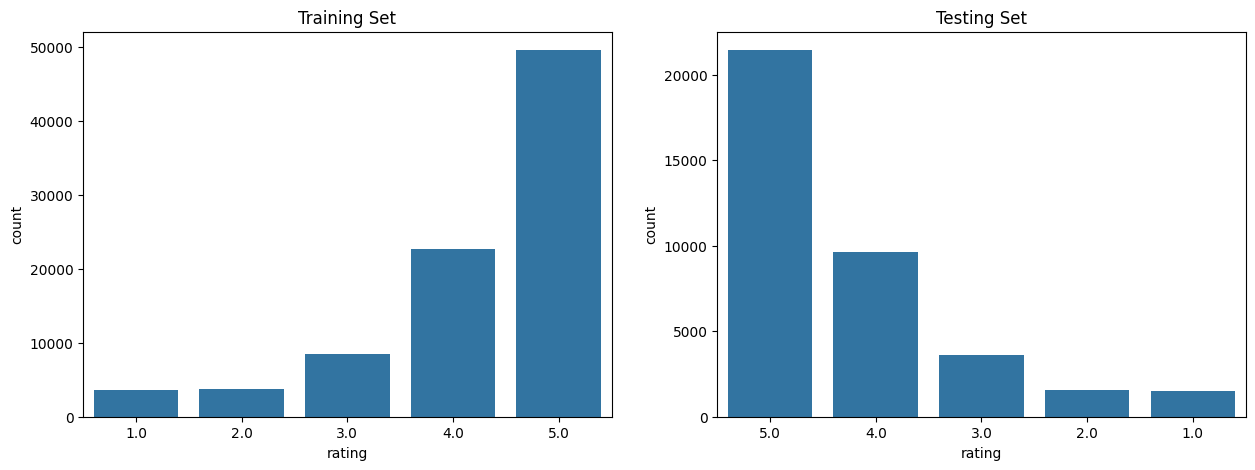

In [ ]:
# Check the ratings distribution in both train and test set
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_title('Training Set')
sns.countplot(x='rating', data=trainset, ax=axes[0])
axes[1].set_title('Testing Set')
sns.countplot(x='rating', data=testset, ax=axes[1],
              order=testset.rating.value_counts().index)

**Observations**:
- Train Test set split resulted into 88109 training data and 37762 testing dataset.
- Both the datasets are having almost equal no of data points under each rating.

---
## Build Rank based Recommender model.
### Rank Based
Easiest way to build a recommendation system is rank based, simply over all the products that are popular, So how to identify popular products, which could be identified by which are all the products that are bought most.

Let's group the products to find the count of reatings each one of them has recieved. this could be considered as their individual scores.

In [ ]:
# Calculating average ratings
average_rating = ratings.groupby('userId')['rating'].mean()

# Calculating the count of ratings
count_rating = ratings.groupby('userId')['rating'].count()

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [ ]:
final_rating.head()

,avg_rating,rating_count
userId,,
A100UD67AHFODS,4.509,116
A100WO06OQR8BQ,3.652,132
A105S56ODHGJEK,3.838,68
A105TOJ6LTVMBG,3.845,71
A10AFVU66A79Y1,4.185,65


In [ ]:
final_rating['rating_count'].value_counts()

rating_count
50     74
52     63
57     58
51     57
53     55
       ..
134     1
173     1
147     1
180     1
189     1
Name: count, Length: 166, dtype: int64

In [ ]:
def top_n_products(data, n, min_interaction=100):

    # Finding products with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values w.r.t. average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get products to recommend.

Recommending top 5 products with 50 minimum interactions based on popularity

In [ ]:
res = list(top_n_products(final_rating, 5, 50))
# Name of the books
list_of_products = []
for i in res:
    list_of_products.append(ratings[ratings['userId']== str(i) ]['productId'].unique()[0])
list_of_products

['B00000J1SC', 'B000067SOH', 'B00005T3VM', 'B00032AVN6', 'B000067TNE']

Recommending top 5 Products with 100 minimum interactions based on popularity

In [ ]:
res = list(top_n_products(final_rating, 5, 100))
# Name of the books
list_of_products = []
for i in res:
    list_of_products.append(ratings[ratings['userId']== str(i) ]['productId'].unique()[0])
list_of_products

['B000CKVOOY', 'B000JSFZPS', 'B00004SCKA', 'B00007EDZG', 'B00004ZCJE']

**Observations:**
- Rank recommender models works based on the Ranks of products.
- The products with highest number of ratings gets recommended irrespective of user's interest. This is the model used as a basic recommendation even when the user is not even logged into Amazon.
- So is observed above that all the 5 users recieved the same recommendations i.e the top n rated products under Electronics category.

---
##  Build Collaborative Filtering model

**Types of Collaborative Filtering (CF)**
- Item Based Collaborative Filtering (IBCF)
  - Compute similarity between Items
- User Based Collaborative Filtering (UBCF)
  - Compute similarity between Users
  
**IBCF vs. UBCF**
- IBCF is more efficient than UBCF
- Typical applications involve far more Users than Items. Hence Similarity matrix for IBCF is more compact than UBCF
- Similarity estimates between items is also more likely to converge over time than similarity between users. Hence the similarities can be pre computed and cached unlike similarity between users that need to be dynamically computed at every certain interval.
- However, the IBCF recommendations tend to be more conservative than UBCF



In [ ]:
def precision_recall_at_k(model, k=10, threshold=3.5):

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions=model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions is calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    # Mean of all the predicted recalls is calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)

    accuracy.rmse(predictions)
    print('Precision: ', precision) # Command to print the overall precision
    print('Recall: ', recall) # Command to print the overall recall
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) # Formula to compute the F-1 score.

In [ ]:
# Calculating average ratings
average_rating = ratings.groupby('productId')['rating'].mean()

# Calculating the count of ratings
count_rating = ratings.groupby('productId')['rating'].count()

# Updating the final_rating dataframe with the new encoded book_id count and average of ratings based on the new dataframe
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})
final_rating.head()

,avg_rating,rating_count
productId,,
0594451647,5.000,1
0594481813,3.000,1
0970407998,2.500,2
0972683275,4.750,4
1400501466,3.333,6


Below we are loading the `data` dataset, which is a pandas dataframe, into a different format called `surprise.dataset.DatasetAutoFolds` which is required by this library. To do this, we will be using the classes `Reader` and `Dataset`

**Making the dataset into surprise dataset and splitting it into train and test set**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 10))

# Loading the rating dataset
data = Dataset.load_from_df(ratings[['userId', 'productId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

Now, we are ready to build the first baseline similarity based recommendation system using cosine similarity and KNN.

### **User-Based Collaborative Filtering Recommendation System**

In [ ]:
sim_options = {'name': 'cosine',
               'user_based': True}

algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False,random=1)

# Train the algorithm on the train set, and predict ratings for the test set
algo_knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =10.
precision_recall_at_k(algo_knn_user)

RMSE: 1.1089
Precision:  0.858
Recall:  0.516
F_1 score:  0.644



**Observations:**

- Intuition of Recall - We are getting a **recall of ~0.51**, which means out of **all the relevant products, 51% are recommended**.
- Intuition of Precision - We are getting a **precision of ~ 0.85**, which means **out of all the recommended products, 85% are relevant**.
- Here **F_1 score** of the **baseline model is ~0.64**. It indicates that **mostly recommended products were relevant and relevant products were recommended**. We can try to improve the performance by using **GridSearchCV to tune different hyperparameters** of the algorithm.

Let's now predict rating for a user with **userId=A3LDPF5FMB782Z** and **productId=1400501466** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
algo_knn_user.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

- We observe that the actual rating for this user-item pair is 8 and predicted rating is 7.99 by this similarity based baseline model, which is good.

Below is the function to find the list of users who have not seen the product with product id "1400501466".

In [ ]:
def n_users_not_interacted_with(n, data, productId):
    users_interacted_with_product = set(data[data['productId'] == productId]['userId'])
    all_users = set(data['userId'])
    return list(all_users.difference(users_interacted_with_product))[:n]

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
n_users_not_interacted_with(5, ratings, 1400501466)

['A1QRST0A3IQIEF',
 'A250AXLRBVYKB4',
 'A3D01HLSUFEZQY',
 'A21Q9JVG4SII51',
 'A1I96OYAUJ3HQE']

- It can be observed from the above list that user **"A2UOHALGF2X77Q" has not seen the product with productId "1400501466"** as this user id is a part of the above list.

In [ ]:
algo_knn_user.predict('A2UOHALGF2X77Q', 1400501466, r_ui=5, verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = 5.00   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A2UOHALGF2X77Q', iid=1400501466, r_ui=5, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

- observations:

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below we will be tuning hyperparameters for the `KNNBasic` algorithms. Let's try to understand different hyperparameters of KNNBasic algorithm -

- **k** (int) – The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - pearson
    - pearson baseline
    
For more details please refer the official documentation https://surprise.readthedocs.io/en/stable/knn_inspired.html

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine', 'pearson','pearson_baseline'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0537013827880466
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is complete, we can get the optimal values for each of those hyperparameters.

Now, let's build the final model by using tuned values of the hyperparameters, which we received by using grid search cross-validation.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6, verbose=False)

# Training the algorithm on the train set
similarity_algo_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k=10.
precision_recall_at_k(similarity_algo_optimized)

RMSE: 1.0563
Precision:  0.837
Recall:  0.504
F_1 score:  0.629


**Observations:**

- After tuning hyperparameters, RMSE for the test set has reduced from 1.10 to 1.05.
- We can observe that after tuning the hyperparameters, the tuned model's F-1 score decreased from 0.64 to 0.62 in comparison to the baseline model. As a result, we can say that the model's performance has not improved after hyperparameter tuning.

In [ ]:
similarity_algo_optimized.predict('A3LDPF5FMB782Z', 1400501466, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=None, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
similarity_algo_optimized.predict('A2UOHALGF2X77Q', 1400501466, verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A2UOHALGF2X77Q', iid=1400501466, r_ui=None, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

We can find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the user_id=0.

In [ ]:
similarity_algo_optimized.get_neighbors(0, k=5)

[3, 4, 6, 8, 10]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: a rating dataset
- user_id:  user_id against which we want the recommendations
- top_n: the number of items we want to recommend
- algo: the algorithm we want to use to predict the ratings
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, userId, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'userId', columns = 'productId', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[userId][user_item_interactions_matrix.loc[userId].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(userId, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
recommendations = get_recommendations(ratings, "A3LDPF5FMB782Z", 5, similarity_algo_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "productId" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['productId', 'predicted_ratings'])

,productId,predicted_ratings
0,B000VX6XL6,5.000
1,B001TH7GUU,5.000
2,B002JQNXZC,5.000
3,B00316263Y,5.000
4,B003ES5ZR8,5.000


### **Model 3: Item based Collaborative Filtering Recommendation System**

* We have seen **user-user similarity-based collaborative filtering**. Now, let us look into similarity-based collaborative filtering where similarity is calculated **between items**.

In [ ]:
# Defining similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False, random_state=1)

# Train the algorithm on the train set
algo_knn_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k=10
precision_recall_at_k(algo_knn_item)

RMSE: 1.1056
Precision:  0.827
Recall:  0.496
F_1 score:  0.62


Let's now predict a rating for a user with userId = A3LDPF5FMB782Z and prod_Id = 1400501466 as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
algo_knn_item.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

Below we are predicting rating for the userId = A2UOHALGF2X77Q and prod_id = 1400501466.

In [ ]:
algo_knn_item.predict('A2UOHALGF2X77Q ', 1400501466, r_ui=5, verbose=True)

user: A2UOHALGF2X77Q  item: 1400501466 r_ui = 5.00   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A2UOHALGF2X77Q ', iid=1400501466, r_ui=5, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Tuning the baseline item-based collaborative filtering recommendation system's hyperparameters and determining the RMSE for the tuned item-based collaborative filtering recommendation system**

In [52]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10,20,30], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Now, let's build the **final model** by using **optimal values of the hyperparameters** which we received by using grid search cross-validation.

In [53]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=20, min_k=6,verbose=False)

# Training the algorithm on the train set
similarity_algo_optimized_item.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(similarity_algo_optimized_item)

RMSE: 1.0582
Precision:  0.825
Recall:  0.497
F_1 score:  0.62


observations:
- the baseline F_1 score and optimized score remained same. its the Same for precision and recall
- the RMSE decreased from 1.10 to 1.05

Predict rating for the user with userId="A3LDPF5FMB782Z", and prod_id= "1400501466" using the optimized model

In [56]:
similarity_algo_optimized_item.predict("A3LDPF5FMB782Z", 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

Predict rating for userId="A2UOHALGF2X77Q" who has not interacted with prod_id ="1400501466", by using the optimized model

In [57]:
similarity_algo_optimized_item.predict("A2UOHALGF2X77Q", 1400501466, r_ui=5, verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = 5.00   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A2UOHALGF2X77Q', iid=1400501466, r_ui=5, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out the similar items to a given item or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar items to the `userId=0`.

In [58]:
similarity_algo_optimized_item.get_neighbors(0, k=5)

[58, 61, 167, 415, 512]

#### Predicted top 5 books for user_id="A1A5KUIIIHFF4U" with similarity based recommendation system


In [59]:
recommendations = get_recommendations(ratings, "A1A5KUIIIHFF4U", 5, similarity_algo_optimized_item)

In [60]:
# Building the dataframe for above recommendations with columns "userId" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['userId', 'predicted_ratings'])

,userId,predicted_ratings
0,B00DTZYHX4,4.565
1,0594451647,4.264
2,0594481813,4.264
3,0970407998,4.264
4,0972683275,4.264


## **Model 4: Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**. The recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

**Latent Features:** The features that are not present in the empirical data but can be inferred from the data.

### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix** that we already learned earlier. But SVD does not work when we **miss values** in the **user-item matrix**.

#### **Building a baseline matrix factorization recommendation system**

In [61]:
# Using SVD matrix factorization
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(svd)

RMSE: 0.9904
Precision:  0.855
Recall:  0.503
F_1 score:  0.633


**Observations:**

- We observe that the **baseline F_1 score** for the matrix factorization model on the test set is lower in comparison to the F_1 score for the user-user similarity-based recommendation system and higher in comparison to the optimized user-user similarity-based recommendation system.
- The result for SVD is better than both baseline and optimized item-item similarity-based recommendation systems.

**What is the predicted  rating for an user with userId = "A3LDPF5FMB782Z" and for prod_id = "1400501466.**

In [62]:
svd.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.11   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.1084942168719305, details={'was_impossible': False})

**What is the predicted  rating for an user with userId = "A2UOHALGF2X77Q" and for prod_id = "1400501466.**

In [63]:
svd.predict('A2UOHALGF2X77Q', 1400501466, r_ui=5, verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = 5.00   est = 4.36   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid=1400501466, r_ui=5, est=4.355906860935246, details={'was_impossible': False})

### **Improving matrix factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

In [64]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.9813462886905783
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


Now, let's **build the final model** by using **optimal values** of the hyperparameters which we received by using grid search cross-validation.

In [65]:
# Building the optimized SVD model
svd_optimized = SVD(n_epochs=30, lr_all=0.005, reg_all=0.2, random_state=1)

# Training the algorithm on the train set
svd_optimized=svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(svd_optimized)

RMSE: 0.9847
Precision:  0.861
Recall:  0.51
F_1 score:  0.641


**Observation:**

- We observe that **after tuning hyperparameters, the model performance has not improved by much**. We can try other values for hyperparameters and see if we can get a better performance. However, here we will proceed with the existing model.

**What is the predicted  rating for an user with userId = "A3LDPF5FMB782Z" and for prod_id = "1400501466.**

In [66]:
svd_optimized.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.129347911019504, details={'was_impossible': False})

**What is the predicted  rating for an user with userId = "A2UOHALGF2X77Q" and for prod_id = "1400501466.**

In [67]:
svd_optimized.predict('A2UOHALGF2X77Q', 1400501466, r_ui=5, verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = 5.00   est = 4.35   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid=1400501466, r_ui=5, est=4.346672860760345, details={'was_impossible': False})

**Now, let's recommend the books using the optimized svd model**

In [69]:
# Getting top 5 recommendations for user_id 1 using "svd_optimized" algorithm
svd_recommendations = get_recommendations(ratings, "A1A5KUIIIHFF4U", 5, svd_optimized)

In [71]:
# Building the dataframe for above recommendations with columns "userId" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['userId', 'predicted_ratings'])

,userId,predicted_ratings
0,B00DTZYHX4,4.565
1,0594451647,4.264
2,0594481813,4.264
3,0970407998,4.264
4,0972683275,4.264


## **Conclusion**

- In this case study, we built recommendation systems using four different algorithms. They are as follows:
  - Rank-based using averages
  - User-user similarity-based collaborative filtering
  - Item-item similarity-based collaborative filtering
  - Model-based (matrix factorization) collaborative filtering

- To demonstrate **"user-user similarity-based collaborative filtering", "item-item similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering"**, **surprise** library has been used. For these algorithms, **grid search cross-validation is used to find the optimal hyperparameters for the data**, and improve the performance of the model**.

- **For performance evaluation** of these models, **precision@k and recall@k** are used. Using these two metrics, the F_1 score is calculated for each working model.

- Overall, the **optimized matrix factorization recommendation system** has given the **best performance** in terms of the F1-Score (~0.64)

- Collaborative Filtering searches for neighbors based on similarity of products preferences and recommend products that those neighbors read while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

- Matrix Factorization has lower RMSE (1.50) due to the reason that it assumes that both products and users are present in some low dimensional space describing their properties and recommend a product based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

- We can try to further improve the performance of these models using hyperparameter tuning.

- We can also try to combine different recommendation techniques to build a more complex model like hybrid recommendation systems.